newest iteration seems good and usable 04/09


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import uproot
import awkward as ak
import os
import scipy.optimize as sc
import matplotlib as mpl
import glob
from matplotlib.path import Path
from collections import Counter
from tqdm import tqdm


In [2]:

## Hardcoded data paths are not ideal but whatever for now

datapath = "/home/haue/repositories/Masters/data/"
iso = "Si" 
_path = datapath + "bananas/" + iso
_p_path = datapath +"bananaexplorer/" +iso
simpath = "/home/haue/repositories/Masters/simdata/"

#outputdir = "/home/haue/repositories/Masters/analysis/python/dataquality/report_figs/"

_files = glob.glob(os.path.join(_path, "*mlio.root"))
_p_file = glob.glob(os.path.join(_p_path, "*mlio.root"))

In [3]:
#### Loading in of the data files storing them in a dictionary can be easily expanded to include multiple isotopes
#Could be done more optimally by doing it dynamically instead of this?
data_files = {
    iso: _files,
    "p_"+iso: _p_file,
}
data_collection = {
    iso : {},
    "p_"+iso : {}
}

data_collection = {isotope: {f"id{i}": {key: [] for key in ["E", "fEdep", "bEdep", "angle", "Edep", "FI", "BI", "pos.fX", "pos.fY", "pos.fZ",
                                                            "tarpos.fX", "tarpos.fY", "tarpos.fZ"]} for i in range(6)} for isotope in data_files}

for isotope, files in data_files.items():
    file_progress = tqdm(files, desc=f"Processing {isotope}", unit="file", total=len(files), bar_format="{l_bar}{bar} {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]")

    for file in file_progress:
        
        ## accesses the tree "a" in the root file
        r = uproot.open(file)["a"]
        ##Dummy array
        if isotope=="p_"+iso:
            dum = r.arrays(["id", "E", "fEdep", "bEdep", "angle", "Edep", "FI", "BI", "pos.fX", "pos.fY", "pos.fZ","tarpos.fX", "tarpos.fY", "tarpos.fZ"])
            xtar = ak.nan_to_num(ak.flatten(dum["tarpos.fX"]))
            ytar = ak.nan_to_num(ak.flatten(dum["tarpos.fY"]))
            ztar = ak.nan_to_num(ak.flatten(dum["tarpos.fZ"]))
        else:
            dum = r.arrays(["id", "E", "fEdep", "bEdep", "angle", "Edep", "FI", "BI", "pos.fX", "pos.fY", "pos.fZ"])
        ## converts it to an awkward array
        ids = ak.flatten(dum["id"])
        Es = ak.nan_to_num(ak.flatten(dum["E"]) / 1e3)
        fEdeps = ak.nan_to_num(ak.flatten(dum["fEdep"]) / 1e3)
        bEdeps = ak.nan_to_num(ak.flatten(dum["bEdep"]) / 1e3)
        angles = ak.nan_to_num(np.rad2deg(ak.flatten(dum["angle"])))
        Edeps = ak.nan_to_num(ak.flatten(dum["Edep"]) / 1e3)
        FIs = ak.flatten(dum["FI"])
        BIs = ak.flatten(dum["BI"])
        xpos = ak.flatten(dum["pos.fX"])
        ypos = ak.flatten(dum["pos.fY"])
        zpos = ak.flatten(dum["pos.fZ"])
        ##Creates entries in data_collection for each key and for each detector for each key
        for i in range(6):
            mask = (ids==i)
            detector_name = f"id{i}"
            data_collection[isotope][detector_name]["E"].extend(Es[mask])
            data_collection[isotope][detector_name]["fEdep"].extend(fEdeps[mask])
            data_collection[isotope][detector_name]["bEdep"].extend(bEdeps[mask])
            data_collection[isotope][detector_name]["angle"].extend(angles[mask])
            data_collection[isotope][detector_name]["Edep"].extend(Edeps[mask])
            data_collection[isotope][detector_name]["FI"].extend(FIs[mask])
            data_collection[isotope][detector_name]["BI"].extend(BIs[mask])
            data_collection[isotope][detector_name]["pos.fX"].extend(xpos[mask])
            data_collection[isotope][detector_name]["pos.fY"].extend(ypos[mask])
            data_collection[isotope][detector_name]["pos.fZ"].extend(zpos[mask])
            if isotope=="p_"+iso:
                data_collection[isotope][detector_name]["tarpos.fX"].extend(xtar[mask])
                data_collection[isotope][detector_name]["tarpos.fY"].extend(ytar[mask])
                data_collection[isotope][detector_name]["tarpos.fZ"].extend(ztar[mask])
            else:
                continue
        file_progress.set_postfix({"Completed": f"{file_progress.n}/{file_progress.total}"})
    #print(f"Processing done for {isotope}!")

Processing Si: 100%|██████████ 11/11 [01:21<00:00,  7.42s/file]
Processing p_Si: 100%|██████████ 11/11 [00:24<00:00,  2.26s/file]


#### Use this first banana plot to define regions of interest of a given peak. The peak value needs to found from a gaussian fit to the data, this has so far been done in root.

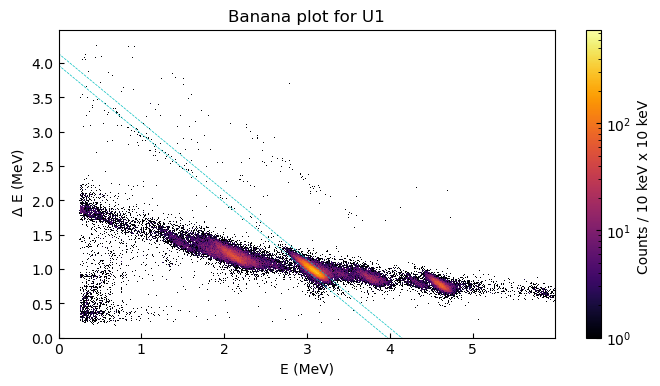

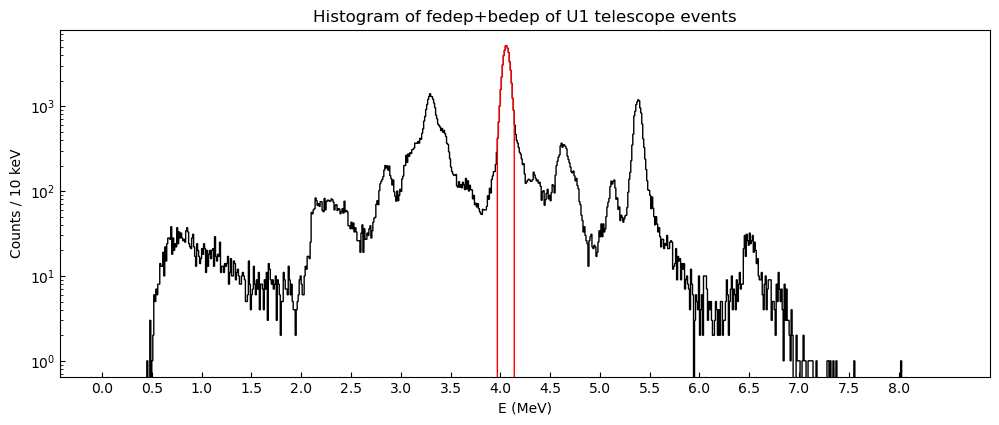

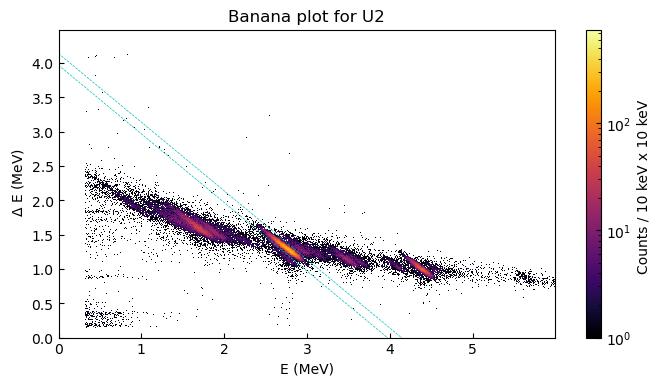

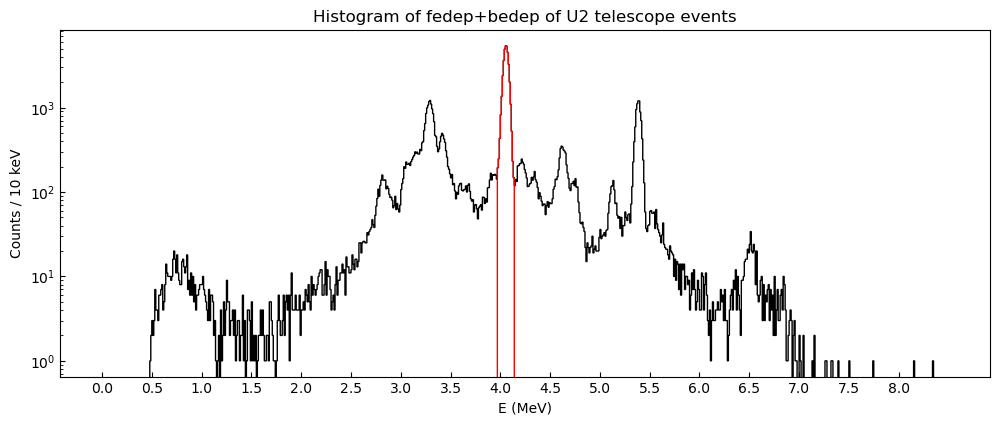

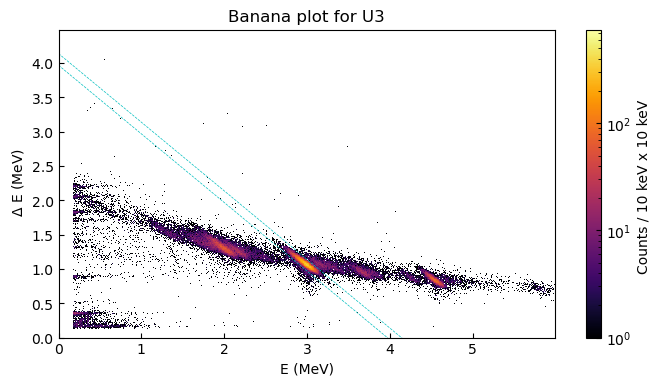

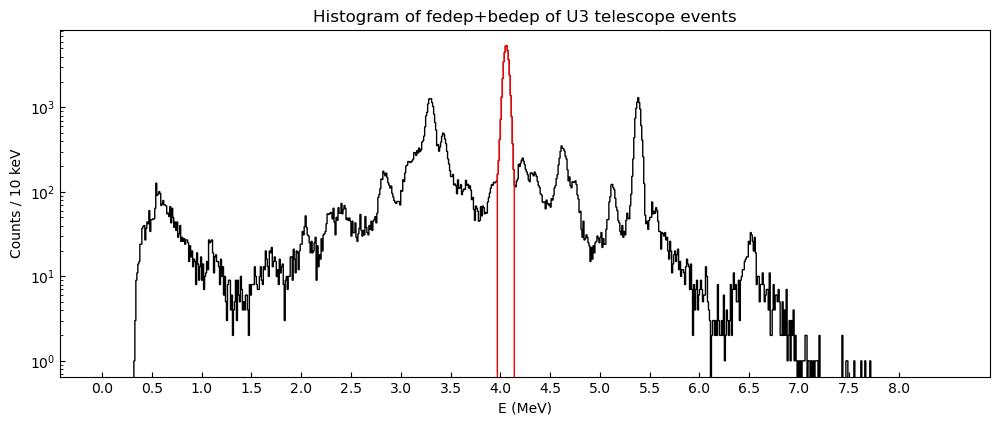

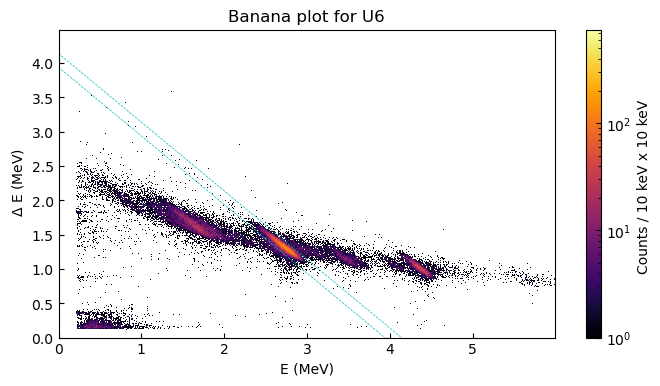

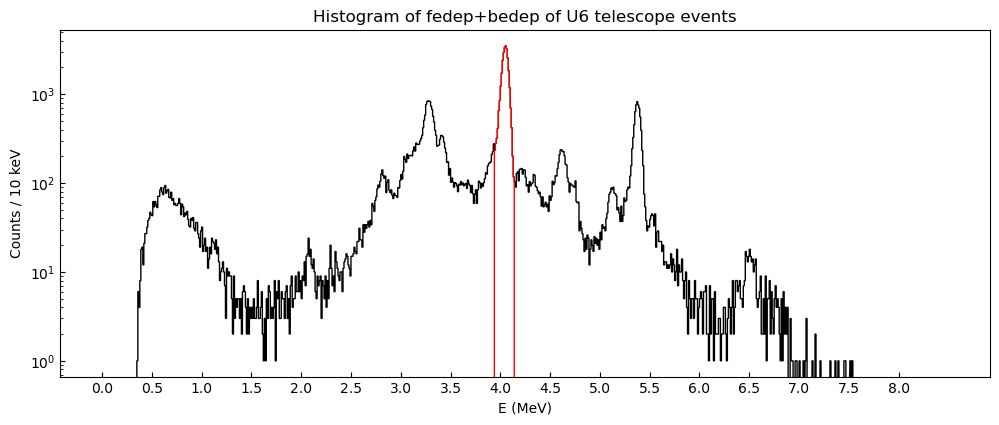

In [4]:

plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"




#lowlim= 5.
#uplim = 5.16
lowlim = 3.92
uplim = 4.12
x = np.linspace(0, 6, 400)


ls = [3.97, 3.97, 3.97, 1, 1, 3.94]#3.96
us = [4.14, 4.14, 4.14, 1, 1, 4.14]# 4.17

### Banana plots to get an idea of the amount of events above the banana
## An idea of the size of the anomalous events
for i in range(6):
    y1 = -x + ls[i]
    y2 = -x + us[i] 
    if i==3 or i==4:
        continue
    det = f"id{i}"
    plt.figure(figsize=(8,4))
    plt.hist2d(data_collection[iso][det]["bEdep"], data_collection[iso][det]["fEdep"], bins=(np.arange(0, 6, 0.01), np.arange(0, 4.5, 0.01)),
                   cmap=plt.cm.inferno, norm=mpl.colors.LogNorm(vmin=1, vmax=750), rasterized=True)       
    cbar = plt.colorbar()
    cbar.ax.set_ylabel(f"Counts / 10 keV x 10 keV ")
    plt.xlabel("E (MeV)")
    plt.ylabel(r" $\Delta$ E (MeV)")
    plt.title(f"Banana plot for U{i+1}")
    plt.plot(x,y1, ls='--', color='c', lw=0.5)
    plt.plot(x,y2, ls='--', color='c', lw=0.5)
 

    plt.plot()


    plt.figure(figsize=(12,4.5))
    æ = [a+b for a,b in zip(data_collection[iso][det]["bEdep"], data_collection[iso][det]["fEdep"]) if a+b>0]
    plt.hist(æ, bins=np.arange(0,8.5,0.01), histtype='step', color='k')
    #plt.hist(data_collection[iso][det]["E"], bins=np.arange(0,8.5,0.01), histtype='step', color='k')

    plt.xlabel("E (MeV)")
    plt.ylabel("Counts / 10 keV")
    plt.yscale('log')
    plt.title(f"Histogram of fedep+bedep of U{i+1} telescope events")
    ø = [m for m in æ if ls[i]<m<us[i]]
    plt.hist(ø, bins=np.arange(0,8.5,0.01), histtype='step', color='r')
    plt.xticks(np.arange(0,8.5,0.5))
    #plt.hist(data_collection[iso][det]["Edep"], bins=np.arange(0,8.5,0.01), histtype='step', color='c')
    #plt.vlines(2.99, 0, 1e2, color='c', ls='--')
    #plt.vlines(3.877, 0, 1e2, color='c', ls='--')
    plt.show()


#### Now run the analysis "bananaexplorer" with the appropriate limits found from the previous plot. These limits are then also written down below in "peaks", "peak_vals" and also write down the number of peaks you wish to analyze